
# Projet python M1

Ce projet a été réalisé dans le cadre du cours d'informatique financière du semestre 1 du M1 272. Il est structuré en deux parties distinctes, chacune présentée dans un notebook dédié.

- **Partie 1** : Analyse des rendements mensuels de 25 portefeuilles d'actions cotées sur le NYSE, l'AMEX et le Nasdaq sur la période 1963-2023. Cette analyse repose sur une décomposition des rendements à partir d'une estimation du modèle à cinq facteurs de Fama et French. 

- **Partie 2** : Développement et mise en œuvre de différentes stratégies de trading simples, telles que la moyenne mobile simple (SMA), l'indicateur RSI ou encore une analyse de sentiments appliquée aux tweets de Donald Trump. Chaque stratégie est ensuite soumise à un backtesting afin d'évaluer sa rentabilité et d'identifier les approches les plus performantes.

Il convient également de préciser qu'aucun module de classe n'a été utilisé conformément aux consignes qui ont été données, bien qu'il aurait été possible de le faire (notamment pour la partie 2).

### **Partie 1 : Estimation et test du modèle de Fama-French à 5 facteurs**


En asset pricing, plusieurs modèles permettent d’évaluer la rentabilité d’un actif financier, le plus connu étant le CAPM. Ce dernier a été élargi avec des approches plus complexes, notamment le modèle de Fama-French à 3 facteurs, puis à 5 facteurs. Dans ce projet, c’est le modèle à 5 facteurs qui sera utilisé pour analyser et décomposer les rendements de 25 portefeuilles d’actions. Les deux premières sections de ce notebook sont dédiées à la gestion et à la préparation des données, tandis que la dernière partie se concentre sur l’application du modèle, son évaluation et son interprétation.

#### **Le modèle de Fama-French à 5 facteurs :**

$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{t}+r_{i}RMW_{t}+c_{i}CMA_{t}+e_{it}$$

- $R_{Ft}$ = taux sans risque
- $R_{MT}$ = taux de rendement du portefeuille du marché
- $e_{it}$ = risque idiosyncratique (ou risque diversifiable) de chaque actif.
- $\beta_{i}, s_{i}, h_{i},r_{i}, c_{i}$ = expositions à chacun des facteurs
- $\alpha_{i}$ = constante. 

Selon la théorie des portefeuilles efficients, on s'attend à avoir $a_{i}=0$. Cette hypothèse peut aussi se justifier par la proposition que l'ensemble des facteurs représentent la totalité des facteurs de risque. Avec les 5 facteurs :

1. le rendement du portefeuille du marché corrigé du taux sans risque : $Mkt-RF$
2. la taille (*Size*) de l'entreprise mesurée par sa capitalisation boursière (nombre d'actions en circulation $\times$ prix d'une action). 
    - Cet effet est mesuré par le facteur $SML_{t}$ égal à la différence de rendement d'un portefeuille de petites entreprises moins celui d'un portefeuille de grandes entreprises.
3. le book to market ratio *B/M* (ratio de la valeur comptable et de la valeur de marché). Une entreprise ayant un ratio B/M elevé sera plutôt sous-évaluée et on s'attend à ce qu'elle ait ura un taux de rendement élevé. 
    - Cet effet est mesuré par le facteur $HML_{t}$ calculé comme la difference de rendements entre des portefeuilles à haut (high)
et faible (Low) ratio B/M
4. la profitabilité anticipée des entreprises : des gains anticipés plus élevés ont tendance à augmenter le taux de rendement (toutes choses égales par ailleurs). Le facteur $RMW_{t}$ est la différence de rendement entre un portefeuille d'entreprises à forte (robust) et faible (weak) rentabilité.

5. les investissements anticipés des entreprises : des investissements plus élevés ont tendance à réduire le taux de rendement (moins de dividendes donc une valeur de marché plus petite).  Le facteur $CMA_{t}$ est la différence entre un portefeuille d'entreprises à faible nivea d'investissement (conservative) et d'entreprises à fort niveau d'investissement (agressive)

Cette partie repose sur des données historiques disponibles sur le site de Kenneth French https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.

### **1. Importation et analyse descriptive des données sur les 5 facteurs**

Pour construire le modèle, il est essentiel d'avoir les historiques de chacun des facteurs ainsi que ceux 25 des portefeuilles avec une période et fréquence identique. Les données des 5 facteurs sont disponibles dans le fichier 'F-F_Research_Data_5_Factors_2x3.csv' du site de Kenneth French. On isole les données sur le taux sans risque (RF) dans un dataframe à part.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importation et formatage des donnees
data_factors=pd.read_csv('/Users/tristan/Desktop/ProjPy/F-F_Research_Data_5_Factors_2x3.csv',skiprows=3)
data_factors.columns.values[0]='date'
data_factors['date'] = pd.to_datetime(data_factors['date'], format='%Y%m',errors='coerce')
data_factors=data_factors.dropna()

#Mis en index de la date
data_factors.set_index(data_factors['date'],inplace=True,drop=True)
#Selection de la periode 
data_factors=data_factors.loc['1963-07':'2023-07']

#Mise en place du taux sans risque dans un df a part
rf=pd.DataFrame(data_factors['RF']).apply(pd.to_numeric)

In [3]:
#Suppression des colonnes redondantes
data_factors.drop(['date','RF'],inplace=True,axis=1)
#Conversion des donnees en float
data_factors=data_factors.apply(pd.to_numeric)

data_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18
1963-08-01,5.07,-0.80,1.80,0.36,-0.35
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24


On vérifie également qu'aucune valeur manquante n'est présente.

In [4]:
data_factors.isna().sum()

Mkt-RF    0
SMB       0
HML       0
RMW       0
CMA       0
dtype: int64

L'évolution de chaque facteur peut être représentée historiquement sur la même échelle et ainsi être visualisée.

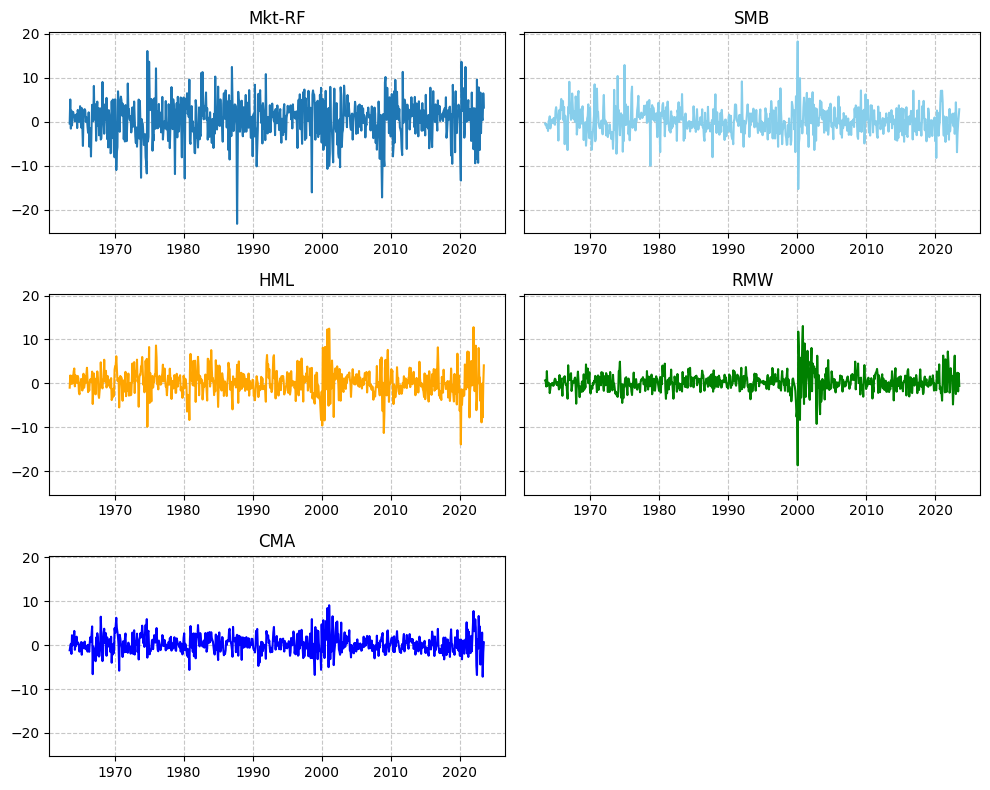

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8),sharey=True)  

axes[0, 0].plot(data_factors['Mkt-RF'], label='MKT-rf')
axes[0, 0].set_title('Mkt-RF')
axes[0, 0].grid(visible=True, linestyle='--', alpha=0.7)

axes[0,1].plot(data_factors['SMB'], label='SMB',color='skyblue')
axes[0,1].set_title("SMB")
axes[0, 1].grid(visible=True, linestyle='--', alpha=0.7)

axes[1,0].plot(data_factors['HML'], label='HML', color='orange')
axes[1,0].set_title("HML")
axes[1, 0].grid(visible=True, linestyle='--', alpha=0.7)

axes[1,1].plot(data_factors['RMW'], label='RMW',color='green')
axes[1,1].set_title("RMW")
axes[1,1].grid(visible=True, linestyle='--', alpha=0.7)

axes[2,0].plot(data_factors['CMA'],label='CMA', color='blue')
axes[2,0].set_title("CMA")
axes[2, 0].grid(visible=True, linestyle='--', alpha=0.7)

axes[2, 1].axis('off')

plt.tight_layout()

Les valeurs mensuelles de chaque facteur peuvent également être représentées sous forme d'histogrammes à échelle identique, offrant une vue d'ensemble de leur répartition et facilitant la comparaison entre les différents facteurs.

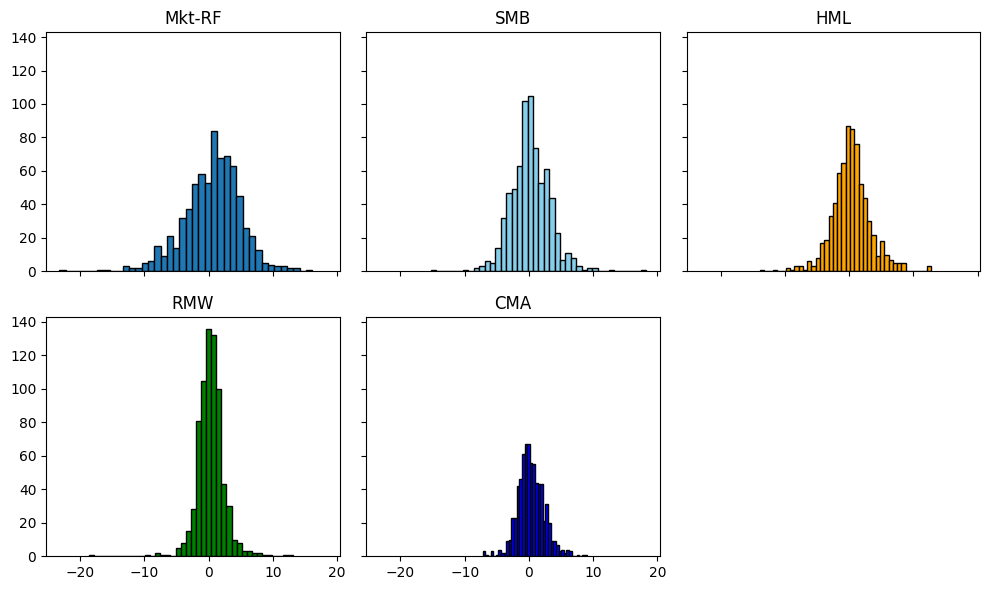

In [6]:
fig, axs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True)

axs[0, 0].hist(data_factors['Mkt-RF'], bins=40, edgecolor='black')
axs[0, 0].set_title('Mkt-RF')

axs[0, 1].hist(data_factors['SMB'], bins=40, edgecolor='black',color='skyblue')
axs[0, 1].set_title('SMB')

axs[0, 2].hist(data_factors['HML'], bins=40, edgecolor='black',color='orange')
axs[0, 2].set_title('HML')

axs[1, 0].hist(data_factors['RMW'], bins=40, edgecolor='black',color='green')
axs[1, 0].set_title('RMW')

axs[1, 1].hist(data_factors['CMA'], bins=40, edgecolor='black',color='blue')
axs[1, 1].set_title('CMA')

axs[1, 2].axis('off')

plt.tight_layout()

Pour simplifier la description des données, une fonction nommée *stat_desc* a été conçue. Elle calcule les moments d'ordre 1 à 4, ainsi que les valeurs maximale et minimale d'un DataFrame. Cette fonction inclut un paramètre booléen *freq_year* qui, lorsqu'il est activé, permet de structurer la description par année en utilisant un multi-index.

In [7]:
def stats_desc(df,freq_year:bool =False) :
    #Cas ou l'on souhaite avoir une seule description pour tout l'echantillon
    if freq_year==False:
        stats = {
            "mean": [df[column].mean() for column in df.columns],
            "max": [df[column].max() for column in df.columns],
            "min": [df[column].min() for column in df.columns],
            "std": [df[column].std() for column in df.columns],
            "skew": [df[column].skew() for column in df.columns],
            "kurt": [df[column].kurtosis() for column in df.columns],
        }

        stats=pd.DataFrame(stats,index=df.columns)
        return stats
    
    #Cas ou l'on souhaite avoir une description pour chaque annee
    else :
        stats_y = {
        "year":[],
        'factor':[],
        "mean": [],
        "max": [],
        "min": [],
        "std": [],
        "skew": [],
        "kurt": []
        }

        for column in df.columns:
    
            annual_data = df[column].resample('YE')
            for date, group in annual_data:
                stats_y["year"].append(date.year)  
                stats_y["factor"].append(column)
                stats_y["mean"].append(group.mean())
                stats_y["max"].append(group.max())
                stats_y["min"].append(group.min())
                stats_y["std"].append(group.std())
                stats_y["skew"].append(group.skew())
                stats_y["kurt"].append(group.kurtosis())

        multi_index = pd.MultiIndex.from_arrays([stats_y['factor'], stats_y['year']],names=['Factor', 'Year'])

        stats_y = pd.DataFrame(stats_y,index=multi_index).drop(['year','factor'],axis=1)
        return stats_y

In [8]:
stats=stats_desc(data_factors).round(2)
stats

,mean,max,min,std,skew,kurt
Mkt-RF,0.57,16.10,-23.24,4.49,-0.50,1.77
SMB,0.22,18.28,-15.32,3.02,0.33,3.07
HML,0.28,12.80,-13.88,3.00,0.08,2.31
RMW,0.28,13.07,-18.65,2.22,-0.27,11.16
CMA,0.28,9.07,-7.20,2.08,0.26,1.46


In [9]:
stats2=stats_desc(data_factors,True).round(2)
stats2

mean   max   min   std  skew  kurt
Factor Year                                    
Mkt-RF 1963  1.10  5.07 -1.57  2.51  0.68 -0.56
       1964  0.97  2.69 -1.44  1.15 -0.60  0.29
       1965  0.84  3.54 -5.51  2.56 -1.42  2.46
       1966 -1.10  3.86 -7.91  3.24 -0.75  0.74
       1967  1.84  8.15 -4.33  3.47 -0.22  0.07
...           ...   ...   ...   ...   ...   ...
CMA    2019 -0.24  3.39 -2.22  1.63  1.13  0.78
       2020 -0.78  1.28 -3.24  1.56  0.00 -1.31
       2021  0.87  5.18 -2.71  2.75  0.23 -1.60
       2022  2.25  7.74 -6.82  4.40 -1.03  0.46
       2023 -1.93  2.85 -7.20  3.27 -0.24  0.22

[305 rows x 6 columns]

En plus de s'intéresser à chaque facteur individuellement, on peut également chercher à évaluer la relation entre ces variables via le coefficient de correlation de Pearson.

Text(0.5, 1.0, 'Heatmap des correlations entre les facteurs')

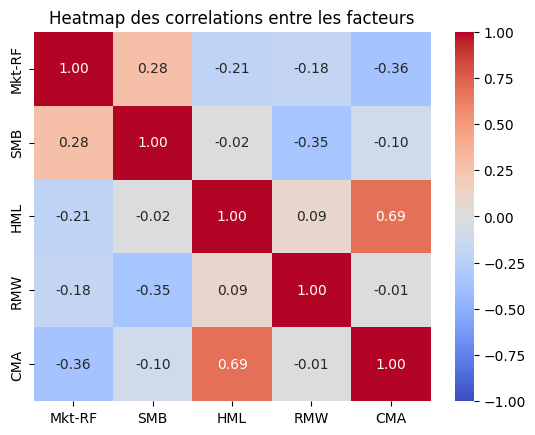

In [10]:
matcorr=data_factors.corr()
sns.heatmap(matcorr,annot=True,vmin=-1,vmax=1,cmap='coolwarm',fmt='.2f')
plt.title('Heatmap des correlations entre les facteurs')

Seuls les facteurs HML et CMA présentent une corrélation positive significative, soulignant une critique fréquente du modèle à 5 facteurs : l'ajout des nouveaux facteurs réduit la pertinence statistique de HML, en rendant ses effets redondants avec ceux de CMA et RMW

La significativité de cette relation peut facilement être vérifiée avec la fonction *pearsonr*.

In [11]:
from scipy.stats import pearsonr

corr, pvalue = pearsonr(data_factors['CMA'],(data_factors['HML']))

print(f'Avec une pvalue de {pvalue},la correlation entre les facteurs CMA et HML est bien significative.') if pvalue < 0.05 else print("La correlation entre les facteurs CMA et HML n'est pas significative au seuil de 5%.")

Avec une pvalue de 8.943508392197456e-102,la correlation entre les facteurs CMA et HML est bien significative.


On peut également s'assurer qu'il n'y a pas de correlation sigificative entre les facteurs HML et SMB.

In [12]:
corr, pvalue = pearsonr(data_factors['HML'],(data_factors['SMB']))

print(f'Avec une pvalue de {pvalue},la correlation entre les facteurs SMB et HML est bien significative.') if pvalue < 0.05 else print(f"Avec une pvalue de {pvalue.round(4)},La correlation entre les facteurs SMB et HML n'est pas significative au seuil de 5%.")

Avec une pvalue de 0.6819,La correlation entre les facteurs SMB et HML n'est pas significative au seuil de 5%.


### **2. Importation des portefeuilles formés selon les ratios B/M et OP**

On importe les rendements de 25 portefeuilles formés à partir des titres du NYSE, de l'AMEX, du Nasdaq pour lesquels on dispose de toutes les quotations. 
Ces actions sont réparties en 25 portefeuilles obtenus par le croisement du ratio *B/M*:
- divisé en 5 catégories LoBM ou BM1/BM2/BM3/BM4/HiBM ou BM5

et de l'Operating Profitability: 
 
- divisé en 5 catégories LoOP ou OP1/OP2/OP3/OP4/HiOP ou OP5

Ces données se trouvent dans le fichier "25_Portfolios_BEME_OP_5x5.CSV".

In [13]:
#Importation et formatage des donnees
data_ptf = pd.read_csv('/Users/tristan/Desktop/ProjPy/25_Portfolios_BEME_OP_5x5_Wout_Div.CSV',encoding='latin1',skiprows=21)
data_ptf=data_ptf.loc[:data_factors.shape[0]-1]
data_ptf.columns.values[0]='date'
data_ptf['date']=pd.to_datetime(data_ptf['date'],format='%Y%m',errors='coerce')

#Mise en index de la date
data_ptf.set_index(data_ptf['date'],inplace=True)
data_ptf.drop(['date'],axis=1,inplace=True)
data_ptf = data_ptf.sort_index().dropna().apply(pd.to_numeric)

In [14]:
data_ptf.head()

,LoBM LoOP,BM1 OP2,BM1 OP3,BM1 OP4,LoBM HiOP,BM2 OP1,BM2 OP2,BM2 OP3,BM2 OP4,BM2 OP5,...,BM4 OP1,BM4 OP2,BM4 OP3,BM4 OP4,BM4 OP5,HiBM LoOP,BM5 OP2,BM5 OP3,BM5 OP4,HiBM HiOP
date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,1.2623,2.3561,0.0607,-1.3786,0.5664,0.9993,1.1767,0.0873,-0.5648,-1.7854,...,-1.9017,-0.6962,-5.3396,0.8350,2.2712,-2.0831,1.3898,2.7043,-2.6274,-1.4786
1963-08-01,5.8711,1.9047,6.0121,5.2857,5.3890,0.9254,3.1166,3.9449,4.8578,5.2287,...,7.1559,5.9545,14.9653,3.8425,11.8604,5.1897,4.7552,2.5373,6.3988,3.3189
1963-09-01,-5.0591,-4.6978,1.3522,-2.0855,-1.2833,-2.1914,-3.4784,0.4944,-2.7454,-4.8934,...,-1.6790,-0.5462,3.6673,-1.4547,-8.5726,-2.9201,-4.8250,-1.0572,-0.4710,-3.3070
1963-10-01,-2.4794,-3.7541,0.7433,3.8618,7.2150,-0.5754,1.8540,2.4607,-0.9950,2.5919,...,2.6678,0.1624,9.8256,6.1852,18.6751,1.1568,1.2259,2.0655,-3.0212,8.2982
1963-11-01,-3.1730,-0.8676,-1.5319,0.5807,-3.6904,-5.8194,-0.4104,1.5279,-1.1904,-2.3474,...,-0.2609,-2.3525,-5.0123,0.6559,5.1434,0.5268,-2.5245,-1.6689,-0.4706,-3.1219


Afin d'établir la variable dépendante du modèle ($ R_{it} - RF_{t}$), il est nécessaire de soustraire pour chaque observation la valeur du taux sans risque correspondant.

In [15]:
prime=data_ptf-rf.values

In [16]:
stats_ptf = stats_desc(data_ptf).sort_values(by='mean',ascending=False)
stats_ptf.round(2)

,mean,max,min,std,skew,kurt
BM4 OP5,1.08,26.42,-33.57,6.98,-0.34,1.83
BM5 OP4,1.08,44.90,-25.12,7.04,0.12,2.97
HiBM HiOP,1.04,55.56,-36.79,8.56,0.41,4.23
BM5 OP3,0.99,25.59,-27.21,5.71,-0.41,2.41
BM3 OP5,0.96,22.58,-25.68,5.58,-0.31,1.97
BM3 OP4,0.88,19.23,-20.75,4.73,-0.36,2.31
HiBM LoOP,0.86,23.64,-32.33,5.87,-0.50,3.07
BM1 OP2,0.86,30.99,-25.76,6.77,-0.04,1.15
BM5 OP2,0.86,27.49,-31.26,5.54,-0.31,3.39
BM4 OP3,0.82,22.01,-26.07,4.79,-0.41,3.65


On constate que les portefeuilles composés d'actions présentant à la fois un ratio valeur comptable sur valeur de marché (BM) élevé et une rentabilité opérationnelle (OP) solide sont généralement les plus performants. Un BM élevé suggère que ces entreprises pourraient être sous-évaluées, offrant ainsi des opportunités d'investissement intéressantes. De plus, une OP robuste indique que ces sociétés gèrent efficacement leurs activités principales et sont donc plus propices à générer du profit. Ainsi, combiner ces deux critères permet de repérer des entreprises potentiellement sous-évaluées mais performantes.

Text(0.5, 0, 'Portefeuille')

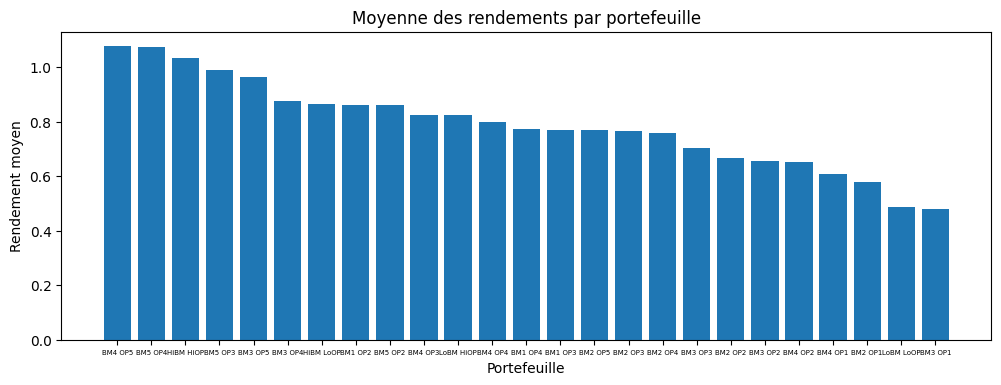

In [17]:
plt.figure(figsize=(12,4))
plt.xticks(fontsize=5)
plt.bar(stats_ptf.index,stats_ptf['mean'])
plt.title('Moyenne des rendements par portefeuille')
plt.ylabel('Rendement moyen')
plt.xlabel('Portefeuille')

### **3. Estimation du modèle de Fama et French**

La fonction *regress* permet d'estimer l'ensemble des coefficients, t-stats et résidus du modèle de Fama-French à 5 facteurs, mais également du modèle à 3 facteurs et du CAPM. Elle prend en argument la liste des rendemnts historiques d'un portefeuille (Y) et la matrice de données des 5 facteurs (X). Tous les résultats ainsi que la moyenne des alphas en valeur absolue sont renvoyés dans un dictionnaire.

In [18]:
#on importe la librairie statsmodels pour effectuer les regressions
import statsmodels.api as sm

def regress(Y,X) -> dict :
    #Ajout de la constante pour chaque modele
    x_1=sm.add_constant(X.iloc[:,0])
    x_3=sm.add_constant(X.iloc[:,:3])
    x_5=sm.add_constant(X.iloc[:,:5])

    m1 = sm.OLS(Y,x_1).fit()
    coef1 = m1.params
    tstat1=m1.tvalues
    resid1=m1.resid

    m2 = sm.OLS(Y,x_3).fit()
    coef2 = m2.params
    tstat2=m2.tvalues
    resid2=m2.resid

    m3 = sm.OLS(Y,x_5).fit()
    coef3 = m3.params
    tstat3=m3.tvalues
    resid3=m3.resid

    alphas_mean = np.mean([abs(coef1.iloc[0]), abs(coef2.iloc[0]), abs(coef3.iloc[0])])

    #On retourne les resultats sous forme de dictionnaire
    results = {
        "coefficients": {
            "1_factor": coef1,
            "3_factors": coef2,
            "5_factors": coef3
        },
        "tstats": {
            "1_factor": tstat1,
            "3_factors": tstat2,
            "5_factors": tstat3
        },
        "residus": {
            "1_factor": resid1,
            "3_factors": resid2,
            "5_factors": resid3
        },
        'alphas':{
            "alphas moyens": alphas_mean,
            "alpha 1 factor": coef1.iloc[0],
            "alpha 3 factors": coef2.iloc[0],
            "alpha 5 factors": coef3.iloc[0]
        }
    }
    
    return results

Grâce à cette fonction, on peut donc estimer les coefficients d'un des trois modèles à partir de n'importe quel vecteur de rendements. Par exemple, pour le portefeuille 'BM4 OP5' réduit du taux sans risque, on trouve pour le modèle à 5 facteurs :

In [19]:
regress(prime['BM4 OP5'],data_factors)['coefficients']['5_factors']

const    -0.269622
Mkt-RF    1.164050
SMB       0.419349
HML       0.817135
RMW       0.299217
CMA      -0.312118
dtype: float64

Soit : $$ BM4OP5_{t} - RF_{t} = \alpha+1.16(RM_{T}-RF_{t})+0.42SMB_{t}+0.82HML_{t}+0.30RMW_{t}-0.31CMA_{t}+e_{t}$$

L'intérêt de cette fonction est qu'elle peut être utilisée dans une boucle itérant sur chaque portefeuille. Elle permet par exemple de déterminer la relation de chacun des portefeuilles avec l'indice de marché diminué du taux sans risque, soit leur beta.

In [20]:
beta_sup = [column for column in prime.columns if regress(prime[column], data_factors)['coefficients']['5_factors'].iloc[1] > 1]
beta_inf = [column for column in prime.columns if regress(prime[column], data_factors)['coefficients']['5_factors'].iloc[1] < 1]

#On utilise la fonction np.isclose car le beta ne sera jamais exactement egal a 1
beta_mid = [column for column in prime.columns if np.isclose(regress(prime[column], data_factors)['coefficients']['5_factors'].iloc[1],1.0,atol=0.001)]

print(
    f"Portefeuille{'s' if len(beta_sup) > 1 else ''} avec beta > 1: {beta_sup}",
    f"Portefeuille{'s' if len(beta_inf) > 1 else ''} avec beta < 1: {beta_inf}",
    f"Portefeuille{'s' if len(beta_mid) > 1 else ''} avec beta très proche de 1 : {beta_mid}",
    sep="\n"
)

Portefeuilles avec beta > 1: ['LoBM LoOP', 'BM1 OP2', 'BM1 OP3', 'BM1 OP4', 'BM2 OP1', 'BM2 OP2', 'BM2 OP3', 'BM2 OP4', 'BM3 OP1', 'BM3 OP5', 'BM4 OP1', 'BM4 OP4', 'BM4 OP5', 'HiBM LoOP', 'BM5 OP2', 'BM5 OP3', 'BM5 OP4', 'HiBM HiOP']
Portefeuilles avec beta < 1: ['LoBM HiOP', 'BM2 OP5', 'BM3 OP2', 'BM3 OP3', 'BM3 OP4', 'BM4 OP2', 'BM4 OP3']
Portefeuille avec beta très proche de 1 : ['BM1 OP4']


Il est également possible de mesurer la significativité de chaque facteur au seuil $\alpha=0.05$ pour chaque portefeuille en comparant leur t-stat en valeur absolue avec le quantile $1-\alpha$ de la loi normale.

In [21]:
ptf_NS_MKT=[column for column in prime.columns if (abs(regress(prime[column], data_factors)['tstats']['5_factors'].iloc[1]) < 1.96)]
ptf_NS_SMB=[column for column in prime.columns if (abs(regress(prime[column], data_factors)['tstats']['5_factors'].iloc[2]) < 1.96)]
ptf_NS_HML=[column for column in prime.columns if (abs(regress(prime[column], data_factors)['tstats']['5_factors'].iloc[3]) < 1.96)]
ptf_NS_RMW=[column for column in prime.columns if (abs(regress(prime[column], data_factors)['tstats']['5_factors'].iloc[4]) < 1.96)]
ptf_NS_CMA=[column for column in prime.columns if (abs(regress(prime[column], data_factors)['tstats']['5_factors'].iloc[5]) < 1.96)]

print('Mkt-RF',f"nombre de portefeuilles dont le facteur Mkt-RF n'est pas significatif : {len(ptf_NS_MKT)}",f'portefeuilles: {ptf_NS_MKT}','',sep='\n')
print('SMB',f"nombre de portefeuilles dont le facteur SMB n'est pas significatif : {len(ptf_NS_SMB)}",f'portefeuilles: {ptf_NS_SMB}','',sep='\n')
print('HML',f"nombre de portefeuilles dont le facteur HML n'est pas significatif : {len(ptf_NS_HML)}",f'portefeuilles: {ptf_NS_HML}','',sep='\n')
print('RMW',f"nombre de portefeuilles dont le facteur RMW n'est pas significatif : {len(ptf_NS_RMW)}",f'portefeuilles: {ptf_NS_RMW}','',sep='\n')
print('CMA',f"nombre de portefeuilles dont le facteur CMA n'est pas significatif : {len(ptf_NS_CMA)}",f'portefeuilles: {ptf_NS_CMA}','',sep='\n')

Mkt-RF
nombre de portefeuilles dont le facteur Mkt-RF n'est pas significatif : 0
portefeuilles: []

SMB
nombre de portefeuilles dont le facteur SMB n'est pas significatif : 5
portefeuilles: ['BM2 OP2', 'BM2 OP3', 'BM2 OP4', 'BM3 OP2', 'BM3 OP3']

HML
nombre de portefeuilles dont le facteur HML n'est pas significatif : 1
portefeuilles: ['BM2 OP3']

RMW
nombre de portefeuilles dont le facteur RMW n'est pas significatif : 6
portefeuilles: ['BM1 OP3', 'BM3 OP2', 'BM4 OP2', 'BM4 OP4', 'BM5 OP2', 'HiBM HiOP']

CMA
nombre de portefeuilles dont le facteur CMA n'est pas significatif : 13
portefeuilles: ['BM1 OP2', 'BM1 OP3', 'LoBM HiOP', 'BM2 OP1', 'BM2 OP5', 'BM3 OP1', 'BM3 OP4', 'BM4 OP1', 'BM4 OP3', 'BM4 OP4', 'HiBM LoOP', 'BM5 OP4', 'HiBM HiOP']



On remarque que le facteur CMA est le plus souvent non significatif (13/25) et qu'au contraire, le facteur de marché Mkt-RF est toujours siginificatif. Cela remet en question encore une fois l'intérêt de l'ajout du facteur CMA dans le modèle.

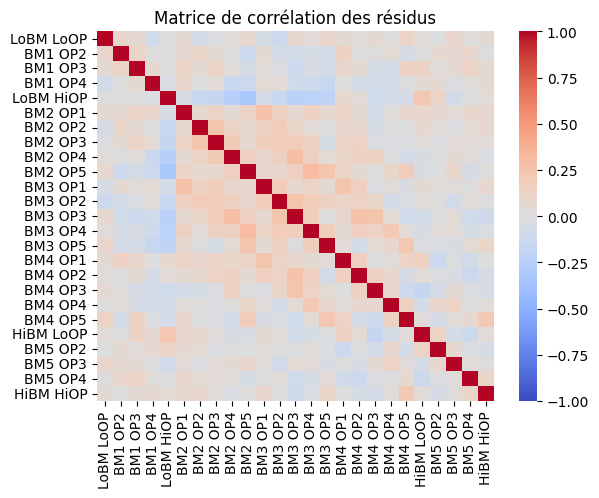

In [22]:
residus = pd.DataFrame([regress(prime[column], data_factors)['residus']['5_factors'] for column in prime.columns]).T
residus_corr=residus.corr()

sns.heatmap(residus_corr, cmap='coolwarm', vmin=-1, vmax=1, xticklabels=data_ptf.columns, yticklabels=data_ptf.columns)
plt.title("Matrice de corrélation des résidus")
plt.show()

In [23]:
#Suppresion des valeurs faussant le calcul de moyenne (1 sur la diagonale)
np.fill_diagonal(residus_corr.values, np.nan)

#Moyenne par colonne
mean_column = residus_corr.mean()
#Moyenne globale
mean_global=mean_column.mean()

print(f"Moyenne des corrélations des résidus : {mean_global}")

Moyenne des corrélations des résidus : 0.033659511330866775


La corrélation des résidus est proche de 0, ce qui suggère que le modèle Fama-French à 5 facteurs parvient à expliquer efficacement la variabilité des rendements des portefeuilles. Cela semble donc indiquer que les erreurs sont indépendantes en moyenne, ce qui valide la pertinence du modèle et l'absence de relations non capturées entre les facteurs et les rendements.

Enfin, la rentabilité de chaque portefeuille peut être évaluée à travers son $\alpha$. Si les modèles sont effectivement valides et conformément à la théorie du portefeuille, les $\alpha$ de chaque portefeuille devraient être nuls ou très proches de zéro, indiquant qu'aucune performance anormale n'est observée après ajustement en fonction des facteurs de risque. On peut facilement déterminer les $\alpha$ de pour chaque portefeuille avec la fonction *regress*.

- **Alpha moyen Fama-French 5 facteurs**

In [24]:
#On calcule les alphas du modele a 5 facteurs pour chaque portefeuille avec la fonction regress
alph=pd.DataFrame({'ptf': prime.columns,'alpha 5f (valeur absolue)':[abs(regress(prime[column], data_factors)['alphas']['alpha 5 factors']) for column in prime.columns]})

#On met en index les noms des portefeuilles
alph.set_index(prime.columns,inplace=True)
alph.drop('ptf',axis=1,inplace=True)

#On peut afficher les alphas du modele a 5 facteurs pour chaque portefeuille 
display(alph.round(2))

,alpha 5f (valeur absolue)
LoBM LoOP,0.04
BM1 OP2,0.02
BM1 OP3,0.02
BM1 OP4,0.04
LoBM HiOP,0.13
BM2 OP1,0.25
BM2 OP2,0.26
BM2 OP3,0.30
BM2 OP4,0.33
BM2 OP5,0.39


In [25]:
#on reutilise la fonction stats_desc pour obtenir les statistiques des alphas du FF5
desc_5f=stats_desc(alph)

- **Alpha moyen Fama-French 3 facteurs**

In [26]:
alph_3f=pd.DataFrame({'ptf': prime.columns,'alpha 3f (valeur absolue)':[abs(regress(prime[column], data_factors)['alphas']['alpha 3 factors']) for column in prime.columns]})
alph_3f.set_index(prime.columns,inplace=True)
alph_3f.drop('ptf',axis=1,inplace=True)

#on reutilise la fonction stats_desc pour obtenir les statistiques des alphas du FF3
desc_3f=stats_desc(alph_3f)

- **Alpha moyen CAPM**

In [27]:
alph_1f=pd.DataFrame({'ptf': prime.columns,'alpha CAPM (valeur absolue)':[abs(regress(prime[column], data_factors)['alphas']['alpha 1 factor']) for column in prime.columns]})
alph_1f.set_index(prime.columns,inplace=True)
alph_1f.drop('ptf',axis=1,inplace=True)

#on reutilise la fonction stats_desc pour obtenir les statistiques des alphas du CAPM
desc_capm=stats_desc(alph_1f)

#### **Conclusion sur les modèles**

In [28]:
#Concatenation des 3 dataframes de description des alphas
desc_global=pd.concat([desc_capm,desc_3f,desc_5f],axis=0)
desc_global.round(2)

,mean,max,min,std,skew,kurt
alpha CAPM (valeur absolue),0.19,0.69,0.01,0.16,1.62,2.90
alpha 3f (valeur absolue),0.27,0.57,0.01,0.15,0.01,-0.76
alpha 5f (valeur absolue),0.28,0.51,0.02,0.14,-0.66,-0.25


Finalement, on constate que le modèle affichant l'alpha moyen le plus faible est également celui qui repose sur le plus petit nombre de facteurs : le CAPM. Autrement dit, le seul facteur de marché suffit à expliquer plus efficacement les rendements des portefeuilles comparé à l'ajout d'autres facteurs. De plus, l'alpha moyen du modèle à 5 facteurs est presque identique à celui du modèle à 3 facteurs, ce qui suggère une nouvelle fois que l'intégration des facteurs RMW et CMA n'apporte pas de réelle amélioration au modèle.

Néanmoins, il est important de rappeler que ces résultats proviennent de régressions réalisées sur un nombre limité de portefeuilles (25) et sur un type spécifique d'actifs (actions). Par conséquent, on ne peut pas en tirer directement des conclusions globales sur la validité de chaque modèle. Il faudrait pour cela mener d'autres analyses plus poussées.